# Setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np

from util import utils
from util import dataloaders
from util.trainer import Trainer

## Load Dataset

In [2]:
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])
])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
images, _ = next(iter(dataloader_train))
images = utils.to_cuda(images)
batch_size, channels, height, width = images.shape
print(f"""
The tensor containing the images has shape:
    batch size  = {batch_size}
    channels    = {channels}
    height      = {height}
    width       = {width}
    max value   = {images.max()}
    min value   = {images.min()}
""")


The tensor containing the images has shape:
    batch size  = 64
    channels    = 1
    height      = 32
    width       = 32
    max value   = 1.0
    min value   = -1.0



### Hyperparameters

In [3]:
learning_rate = .02
num_epochs = 5

### Loss Function

In [4]:
loss_function = torch.nn.CrossEntropyLoss()

# Task 2a
Implement the network in Table 1. Report the final accuracy on the validation set for the trained network. Include a plot of the training and validation loss during training.
By looking at the final train/validation loss/accuracy, do you see any evidence of overfitting? Shortly summarize your reasoning.

# Create Model

In [5]:
def create_model():
    torch.random.manual_seed(0)
    np.random.seed(0)
    model = nn.Sequential(
        # Layer 1
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 2
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(), 
        # Layer 4
        nn.Linear(128 * 4 * 4, 64),
        nn.ReLU(),
        # Layer 5
        nn.Linear(64, 10),
        # nn.Softmax(dim=1),
    )
    model = utils.to_cuda(model)
    utils.test_model_forward_pass(model, images, batch_size)
    return model

model = create_model()

### Verifying the total number of parameters in the model

In [6]:
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 224970


# Train the Model

In [7]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate) # Stochastic Gradient Descent
)
train_loss, test_loss = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [01:37<00:00,  9.57it/s]


In [9]:
loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"""
    Loss: {loss:.2f}
Accuracy: {accuracy:.2f}
""")


    Loss: 0.04
Accuracy: 0.99



# Plot Results

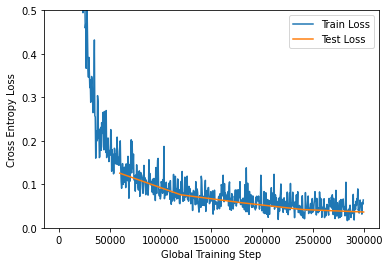

In [10]:
utils.plot_loss(train_loss, label="Train Loss")
utils.plot_loss(test_loss, label="Test Loss")
utils.show_and_save_loss_plot("task2a.png")

# Task 2b
The optimizer in pytorch is the method we use to update our gradients. Till now, we have used standard stochastic gradient descent (SGD). Understanding what the different optimizers do is out of the scope of this course, but we want to make you aware that they exist. 

Adam is one of the most popular optimizers currently. Change the SGD optimizer to Adam (use torch.optim.Adam instead of torch.optim.SGD), and train your model from scratch.
Use a learning rate of 0.001.

Plot the training/validation loss from both models (the model with Adam and the one with SGD) in the same graph and include this in your report. (Note, you should probably change the plt.ylim argument to [0, 0.1]).

In [11]:
model = create_model()

In [12]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=torch.optim.Adam(model.parameters(), lr=0.001) # Adam
)
train_loss_adam, test_loss_adam = trainer.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [01:38<00:00,  9.50it/s]


In [13]:
loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"""
    Loss: {loss:.2f}
Accuracy: {accuracy:.2f}
""")


    Loss: 0.03
Accuracy: 0.99



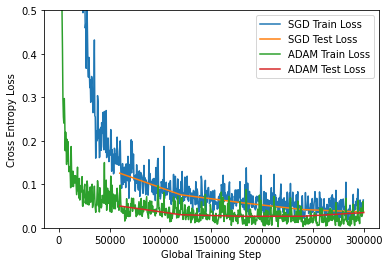

In [14]:
utils.plot_loss(train_loss, label="SGD Train Loss")
utils.plot_loss(test_loss, label="SGD Test Loss")
utils.plot_loss(train_loss_adam, label="ADAM Train Loss")
utils.plot_loss(test_loss_adam, label="ADAM Test Loss")
utils.show_and_save_loss_plot("task2b.png")